In [1]:
import os, sys
import numpy as np
import corner

# sys.path.append('../')
import py21cmfish as p21fish

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mathtext as mathtext
import matplotlib.lines as mlines

%matplotlib inline

plt.style.use(['default','seaborn','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['figure.dpi'] = 150

if os.path.exists(os.environ['WORK_DIR']+'/code/matplotlibrc'):
    from matplotlib import rc_file
    rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

    mathtext.FontConstantsBase.sup1 = 0.5
    mathtext.FontConstantsBase.sub1 = 0.2
    mathtext.FontConstantsBase.sub2 = 0.2

In [3]:
# Color palette
try:
    from palettable.tableau import Tableau_20, ColorBlind_10
    cols = ColorBlind_10.hex_colors

    col_pess  = cols[6]
    col_mod   = cols[0]
    col_alpha = 'k'
    col_mcmc  = cols[3]
    col_P19   = cols[1]

except:
    col_pess  = '0.5'
    col_mod   = 'tab:blue'
    col_alpha = 'k'
    col_mcmc  = '0.7'
    col_P19   = 'tab:orange'

In [4]:
%load_ext autoreload
%autoreload 2

# Fisher plots

This notebook loads and plots posteriors based on the 21cm power spectrum for the 21cmfish paper.

To run the notebook you must first unpack the data directories in `/examples/`

1. [EOS21 - CDM fiducial with pop II and pop III galaxies](#EOS21)
2. [Comparison with Park+19](#Comparison-to-Park+19)
3. [Adding your own new parameter](#Adding-a-new-parameter)

In [23]:
p21fish.base_path = '/Users/cmason/Documents/Research/21cmFAST/21cmfish/'

examples_dir = p21fish.base_path+'examples/'
data_dir     = examples_dir+'data/'

noise_dir = data_dir+'21cmSense_noise/'
figs_dir  = examples_dir

print('Loading data from',data_dir)

Loading data from /Users/cmason/Documents/Research/21cmFAST/21cmfish/examples/data/


# EOS21

This is a fiducial case from [Munoz+2021](#) with CDM, and with both pop II and pop III galaxies.

In [7]:
# Find the parameters we varied and fiducials from the config file
# but you could also list these yourself (especially if you want to change the order)
print(p21fish.base_path+'21cmFAST_config_files/EoS_mini.config')
astro_params_vary, astro_params_fid = p21fish.get_params_fid(
                                        config_file=p21fish.base_path+'21cmFAST_config_files/EoS_mini.config')

print('Varying parameters:',astro_params_vary)
print('Fiducial parameter values:',astro_params_fid)

assert type(astro_params_vary) == list, 'astro_params_vary must be a list'
assert type(astro_params_fid) == dict, 'astro_params_vary must be a dict'

/Users/cmason/Documents/Research/21cmFAST/21cmfish/21cmFAST_config_files/EoS_mini.config
Varying parameters: ['ALPHA_STAR', 'F_STAR10', 'ALPHA_ESC', 'F_ESC10', 'ALPHA_STAR_MINI', 'F_STAR7_MINI', 'F_ESC7_MINI', 'L_X', 'NU_X_THRESH', 'A_LW']
Fiducial parameter values: {'ALPHA_ESC': -0.3, 'F_ESC10': -1.35, 'ALPHA_STAR': 0.5, 'F_STAR10': -1.25, 't_STAR': 0.5, 'F_STAR7_MINI': -2.5, 'ALPHA_STAR_MINI': 0.0, 'F_ESC7_MINI': -1.35, 'L_X': 40.5, 'L_X_MINI': 40.5, 'NU_X_THRESH': 500.0, 'A_VCB': 1.0, 'A_LW': 2.0}


## Load parameters

### Moderate noise

In [9]:
# Load each parameter into a dictionary
params_EoS = {}
astro_params_vary_EoS = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 
                         'F_STAR7_MINI', 'ALPHA_STAR_MINI', 'F_ESC7_MINI', 'A_LW', 'L_X', 'NU_X_THRESH',]

for param in astro_params_vary_EoS:
    params_EoS[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/', 
                                          PS_err_dir=noise_dir+'21cmSense_fid_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=False, new=False)

########### fisher set up for F_STAR10
    Loading global signal and power spectra from saved files
    Fiducial: F_STAR10=-1.25
########### fisher set up for ALPHA_STAR
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_STAR=0.5
########### fisher set up for F_ESC10
    Loading global signal and power spectra from saved files
    Fiducial: F_ESC10=-1.35
########### fisher set up for ALPHA_ESC
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_ESC=-0.3
########### fisher set up for F_STAR7_MINI
    Loading global signal and power spectra from saved files
    Fiducial: F_STAR7_MINI=-2.5
########### fisher set up for ALPHA_STAR_MINI
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_STAR_MINI=0.0
########### fisher set up for F_ESC7_MINI
    Loading global signal and power spectra from saved files
    Fiducial: F_ESC7_MINI=-1.35
########### fisher set up for A_LW
    Loading global signal and power 

### Pessimistic noise

In [10]:
# Load each parameter into a dictionary
params_EoS_pess = {}

for param in astro_params_vary_EoS:
    params_EoS_pess[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/',
                                          PS_err_dir=noise_dir+'21cmSense_pess_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=False)

########### fisher set up for F_STAR10
    Loading global signal and power spectra from saved files
    Fiducial: F_STAR10=-1.25
########### fisher set up for ALPHA_STAR
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_STAR=0.5
########### fisher set up for F_ESC10
    Loading global signal and power spectra from saved files
    Fiducial: F_ESC10=-1.35
########### fisher set up for ALPHA_ESC
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_ESC=-0.3
########### fisher set up for F_STAR7_MINI
    Loading global signal and power spectra from saved files
    Fiducial: F_STAR7_MINI=-2.5
########### fisher set up for ALPHA_STAR_MINI
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_STAR_MINI=0.0
########### fisher set up for F_ESC7_MINI
    Loading global signal and power spectra from saved files
    Fiducial: F_ESC7_MINI=-1.35
########### fisher set up for A_LW
    Loading global signal and power 

## Fisher matrix analysis

`make_fisher_matrix()` creates the Fisher matrix and its inverse from a Parameters dictionary. The resulting ellipses can be plotted with `plot_triangle()`.

In [11]:
Fij_matrix_PS, Finv_PS = p21fish.make_fisher_matrix(params_EoS, fisher_params=astro_params_vary_EoS, 
                                                     hpeak=0.0, obs='PS',
                                                     k_min=0.1, k_max=1, 
                                                     z_min=5., z_max=30., 
                                                     sigma_mod_frac=0.2,
                                                     add_sigma_poisson=True)

fid_params = np.array([astro_params_fid[param] for param in params_EoS])
fid_labels = np.array([p21fish.astro_params_labels[param] for param in params_EoS])

PS shape: (23, 24)


generating new axis


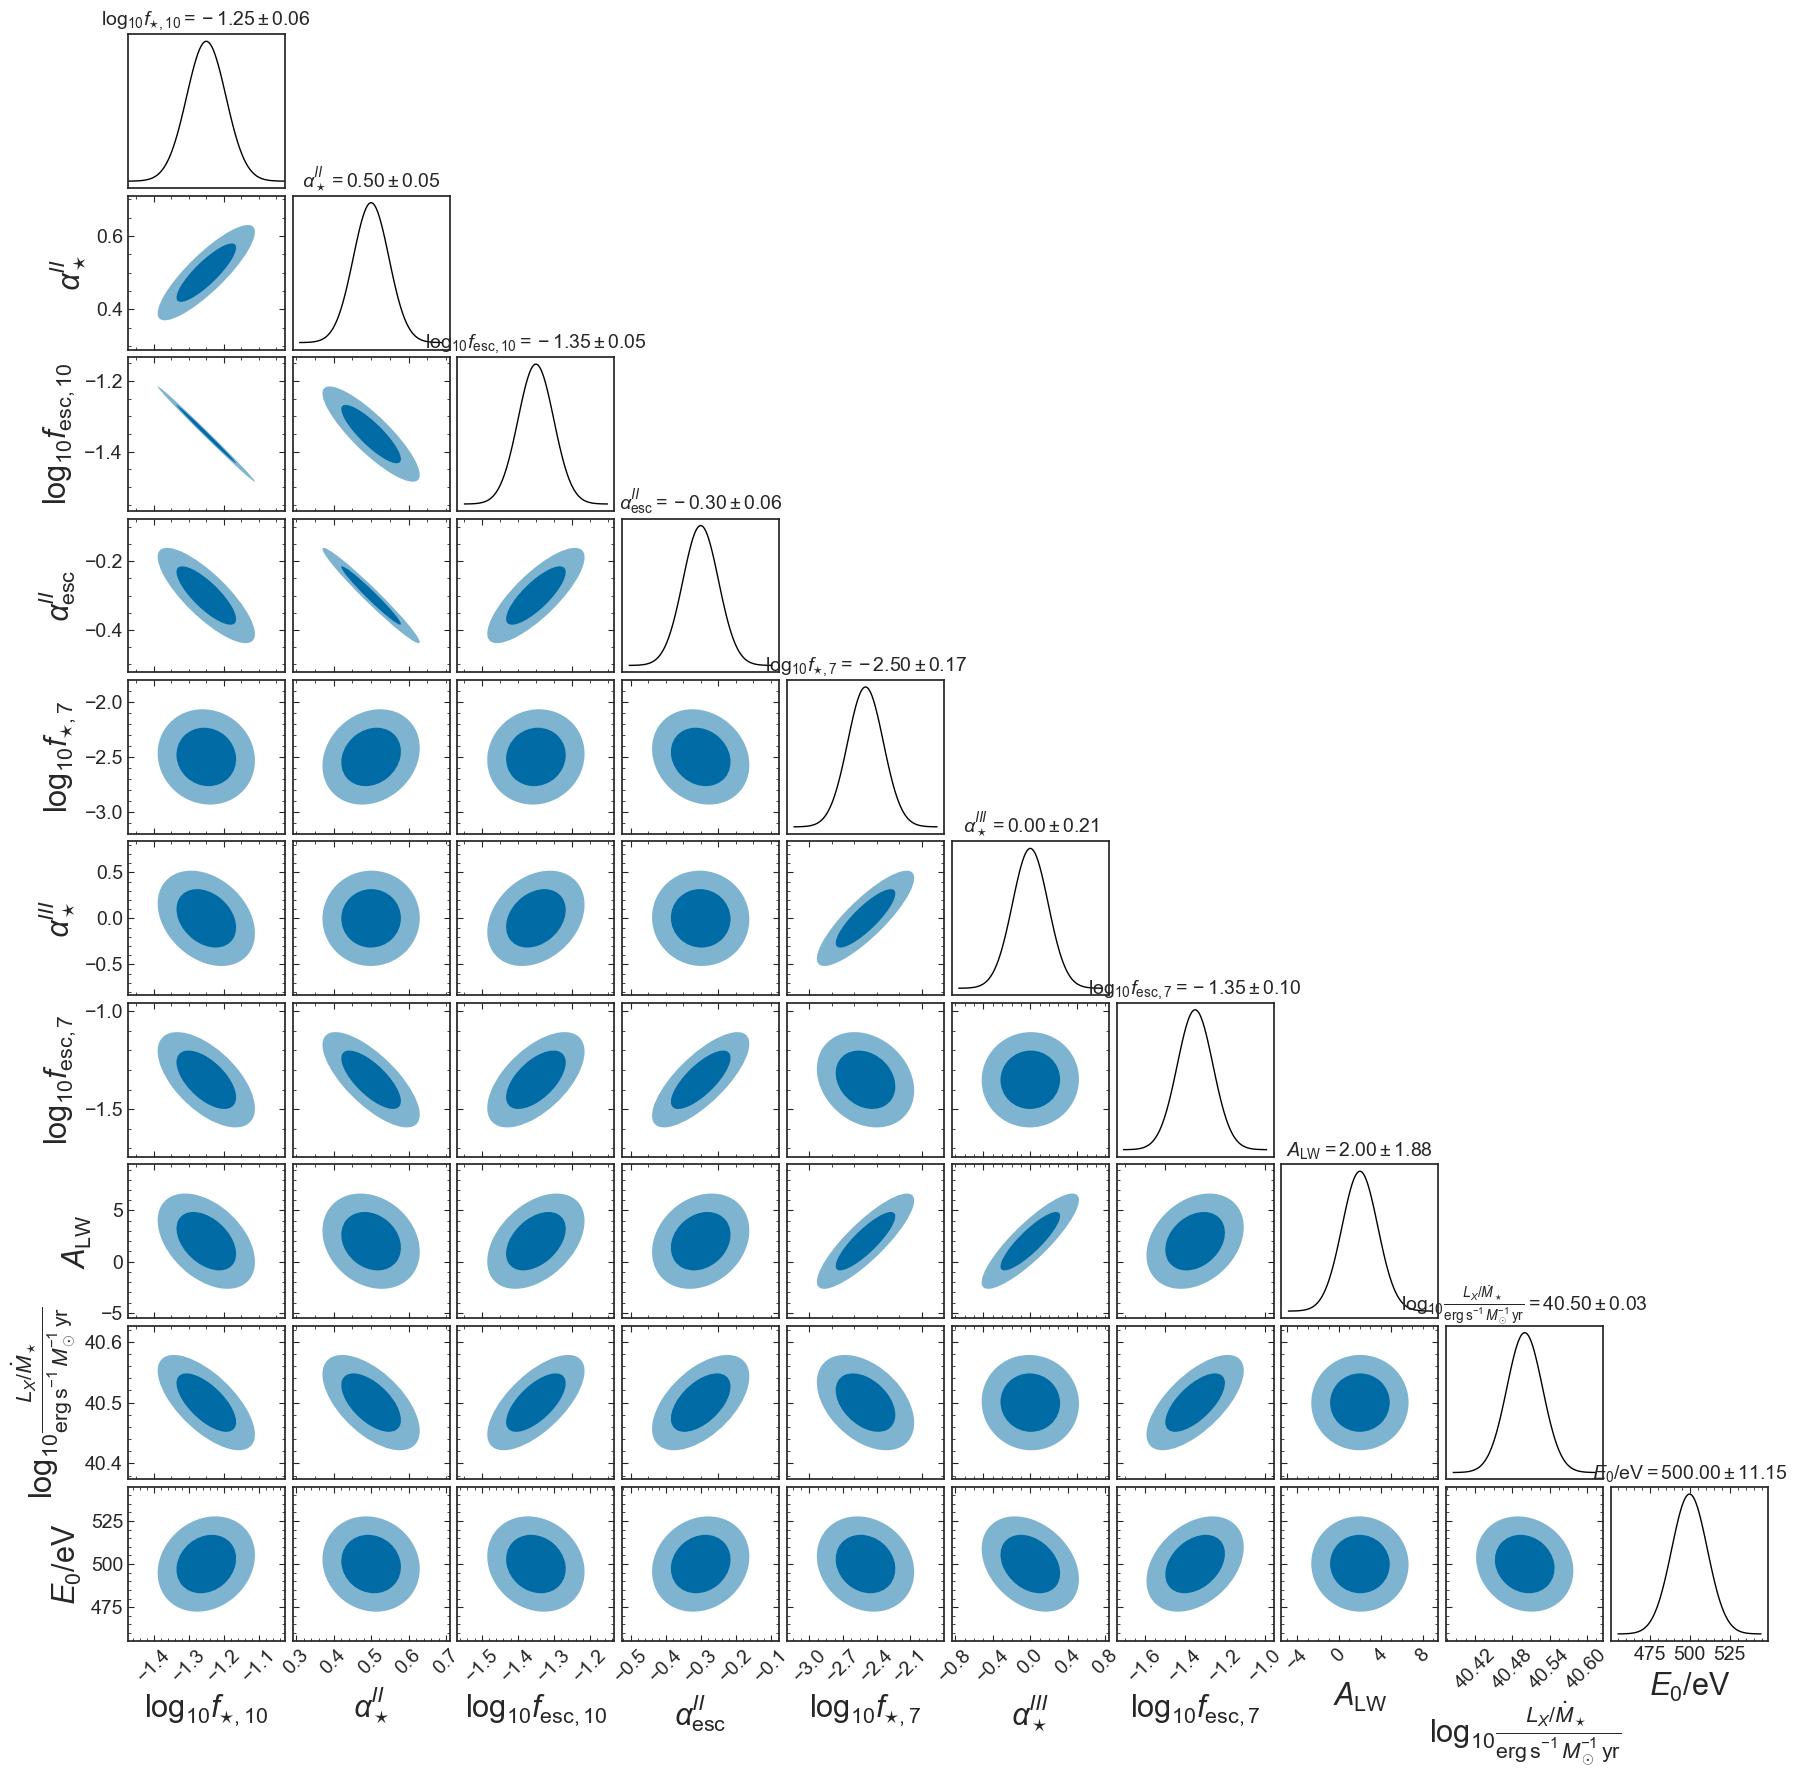

In [12]:
p21fish.plot_triangle(params=astro_params_vary_EoS, 
                      fiducial=fid_params,
                      labels=fid_labels,
                      cov=Finv_PS,
                      ellipse_color=col_mod,
                      title_fontsize=14,
                      xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                      ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                      fig_kwargs={'figsize':(18,18)});

plt.savefig(figs_dir+'corner_EoS_mini_fisher.png', bbox_inches='tight')

## Add a prior

E.g. [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) find $\sigma(\alpha_\star^{II}) \approx 0.07$.

To add a prior, we can add 1/$\sigma^2$ to the diagonal element for that parameter (e.g. [Coe 2009](arXiv:0906.4123))

In [13]:
sigma_alpha_star_II = 0.07
idx_alpha_star = list(params_EoS).index("ALPHA_STAR")
print(f'ALPHA_STAR is at index={idx_alpha_star}')
Fij_matrix_PS_alpha_star_prior = Fij_matrix_PS.copy()
Fij_matrix_PS_alpha_star_prior[idx_alpha_star,idx_alpha_star] += 1/sigma_alpha_star_II**2.

Finv_alpha_star_prior = np.linalg.inv(Fij_matrix_PS_alpha_star_prior)

ALPHA_STAR is at index=1


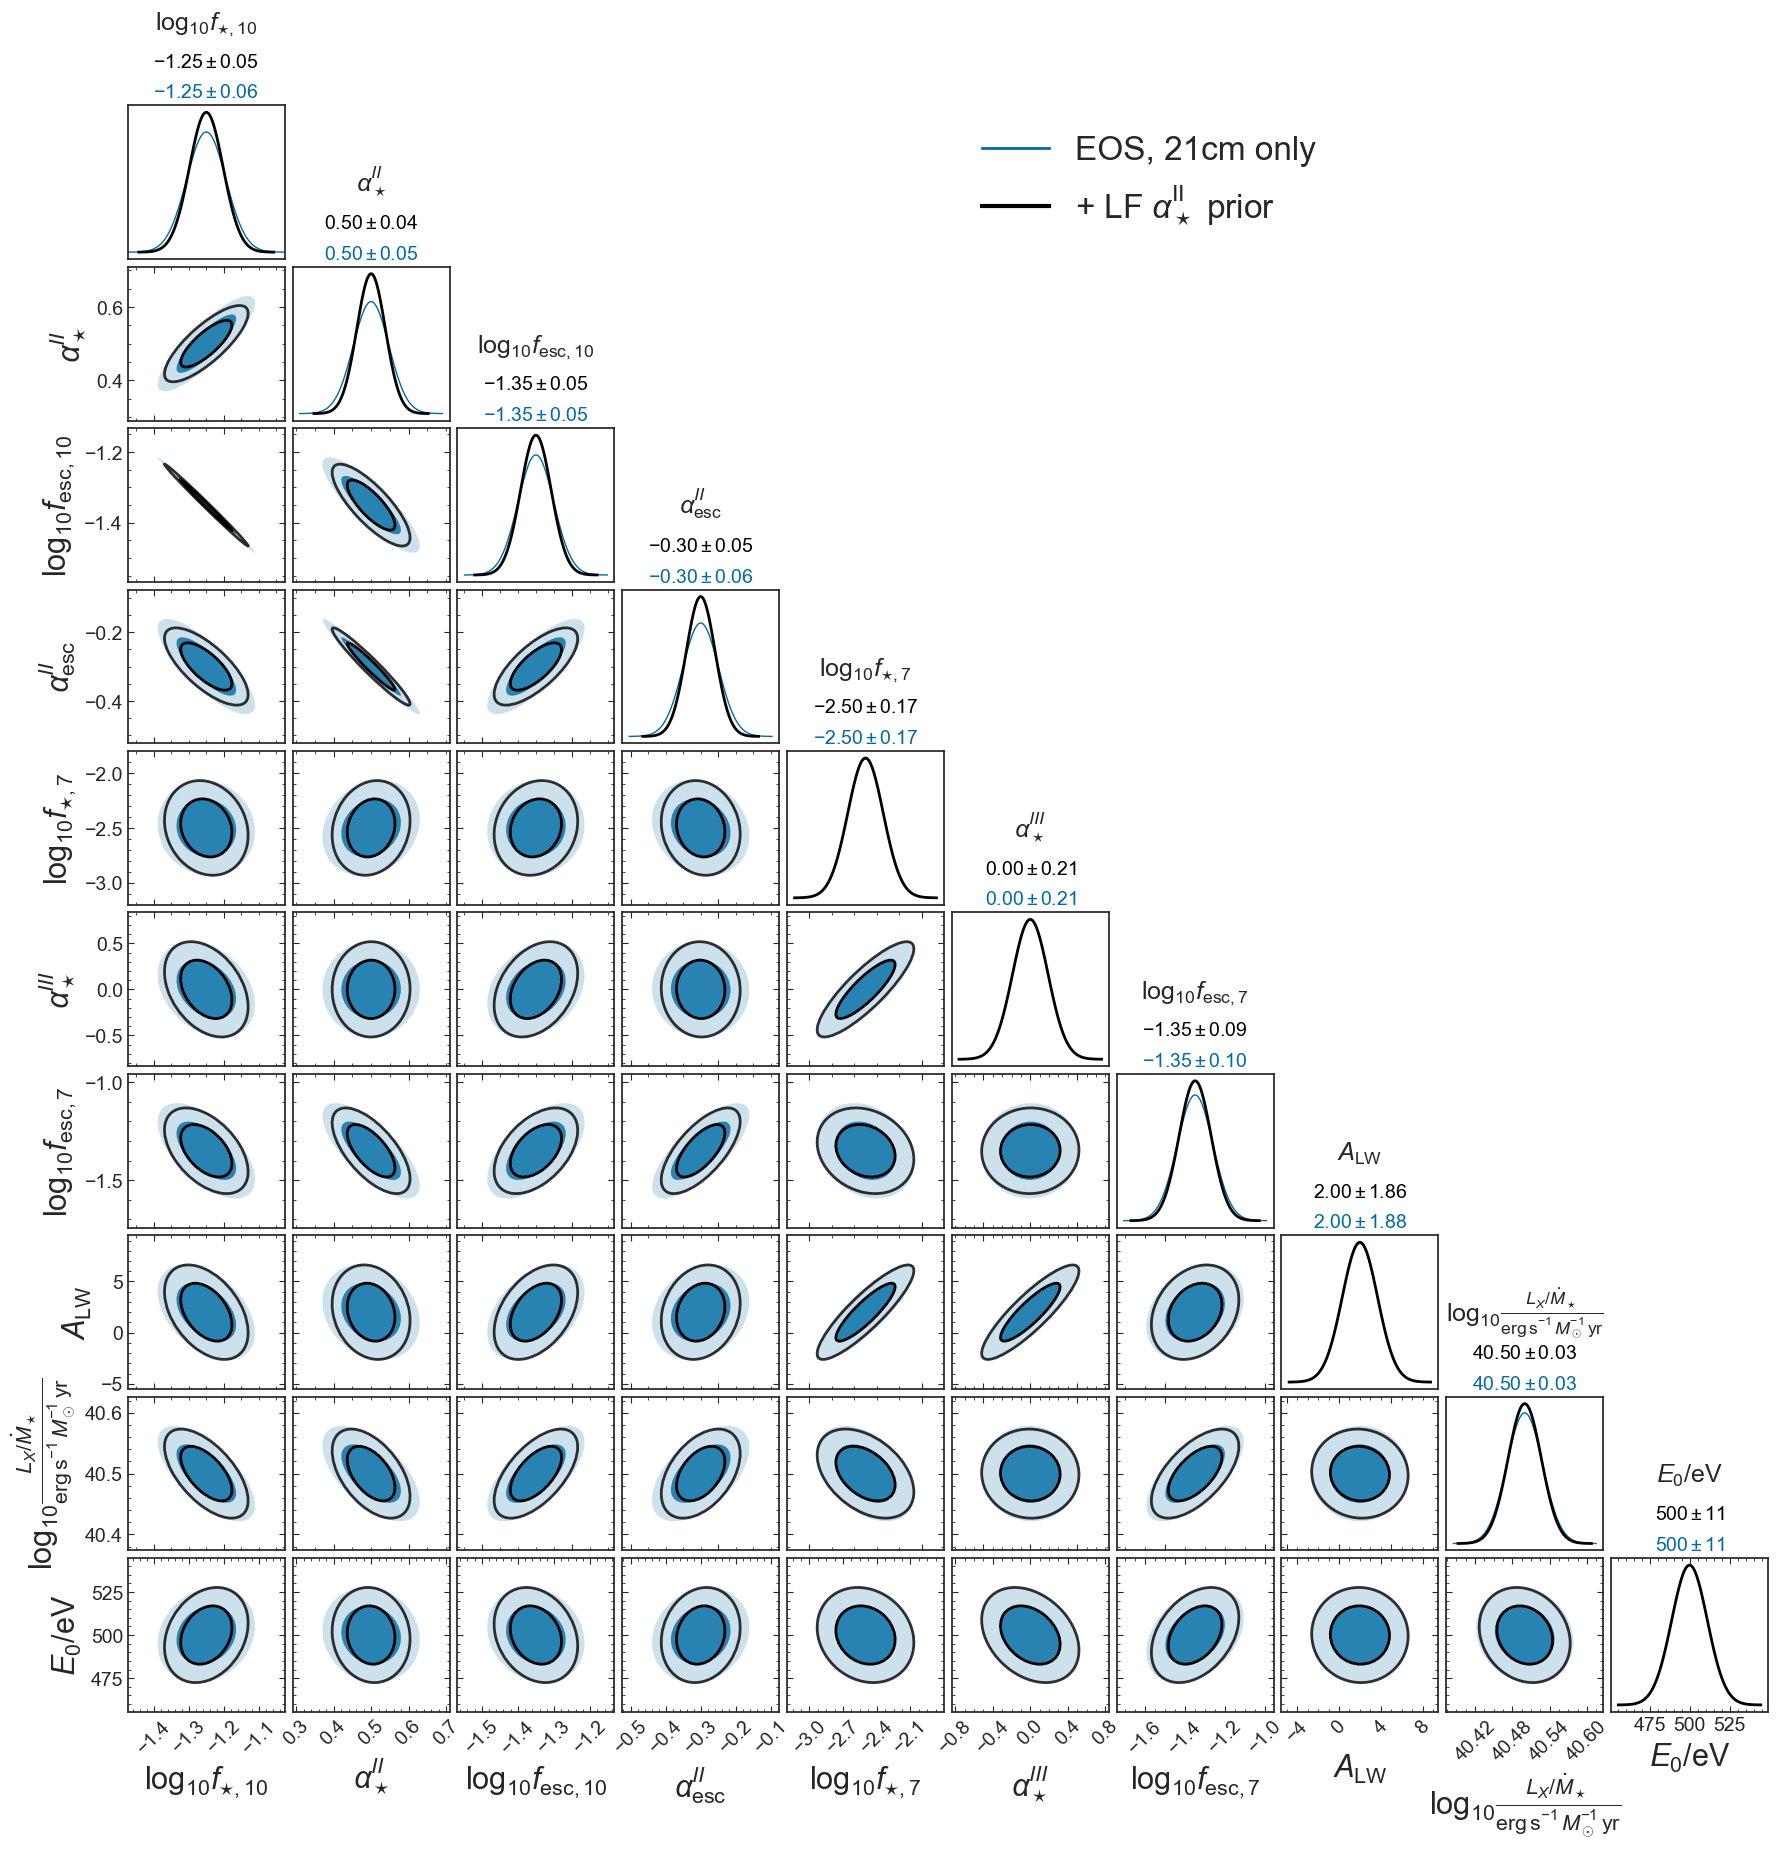

In [14]:
fig, ax = plt.subplots(len(fid_params), len(fid_params), figsize=(18,18))
cols = [col_mod, col_alpha]

for i, cov in enumerate([Finv_PS, Finv_alpha_star_prior]):

    col = cols[i]    
    if i == 0:
        # No prior
        resize_lims=True
        ellipse_color=col
        ellipse_kwargs=[{'alpha':0.8},{'alpha':0.2}]
        plot1D_kwargs={'c':col, 'lw':1}
    else:
        # with prior
        ls='solid'
        resize_lims=False
        ellipse_color='None'
        ellipse_kwargs=[{'edgecolor':col,'lw':2,'ls':ls},
                      {'edgecolor':col,'lw':2,'ls':ls,'alpha':0.8}]
        plot1D_kwargs={'c':col, 'lw':2, 'ls':ls}
        
    p21fish.plot_triangle(params=astro_params_vary_EoS, 
                          fiducial=fid_params,
                          labels=fid_labels,
                          cov=cov,
                          ellipse_color=ellipse_color,
                          ellipse_kwargs=ellipse_kwargs,
                          plot1D_kwargs=plot1D_kwargs,
                          resize_lims=resize_lims,
                          title_fontsize=14,
                          xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ax=ax, fig=fig);

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels,
               med=fid_params, sigma=np.sqrt(cov.diagonal()),
               title_fontsize=18, title_pad=55,
               vspace=i/5,
               color=col
               )

no_prior = mlines.Line2D([], [], color=col_mod, lw=2, label='EOS, 21cm only')
w_prior  = mlines.Line2D([], [], color=col_alpha, lw=3, ls=ls, label=r'+ LF $\alpha_\star^\mathrm{II}$ prior')

ax[0,5].legend(handles=[no_prior, w_prior], loc='upper left', fontsize=24)

plt.savefig(figs_dir+'corner_EoS_mini_fisher_ALPHA_STAR_prior.png', bbox_inches='tight')

## Pessimistic noise case

In [15]:
Fij_matrix_PS_pess, Finv_PS_pess = p21fish.make_fisher_matrix(params_EoS_pess, 
                                                             fisher_params=astro_params_vary_EoS, 
                                                             hpeak=0.0, obs='PS',
                                                             k_min=0.1, k_max=1, 
                                                             z_min=5., z_max=30., 
                                                             sigma_mod_frac=0.2,
                                                             add_sigma_poisson=True) 

PS shape: (23, 24)


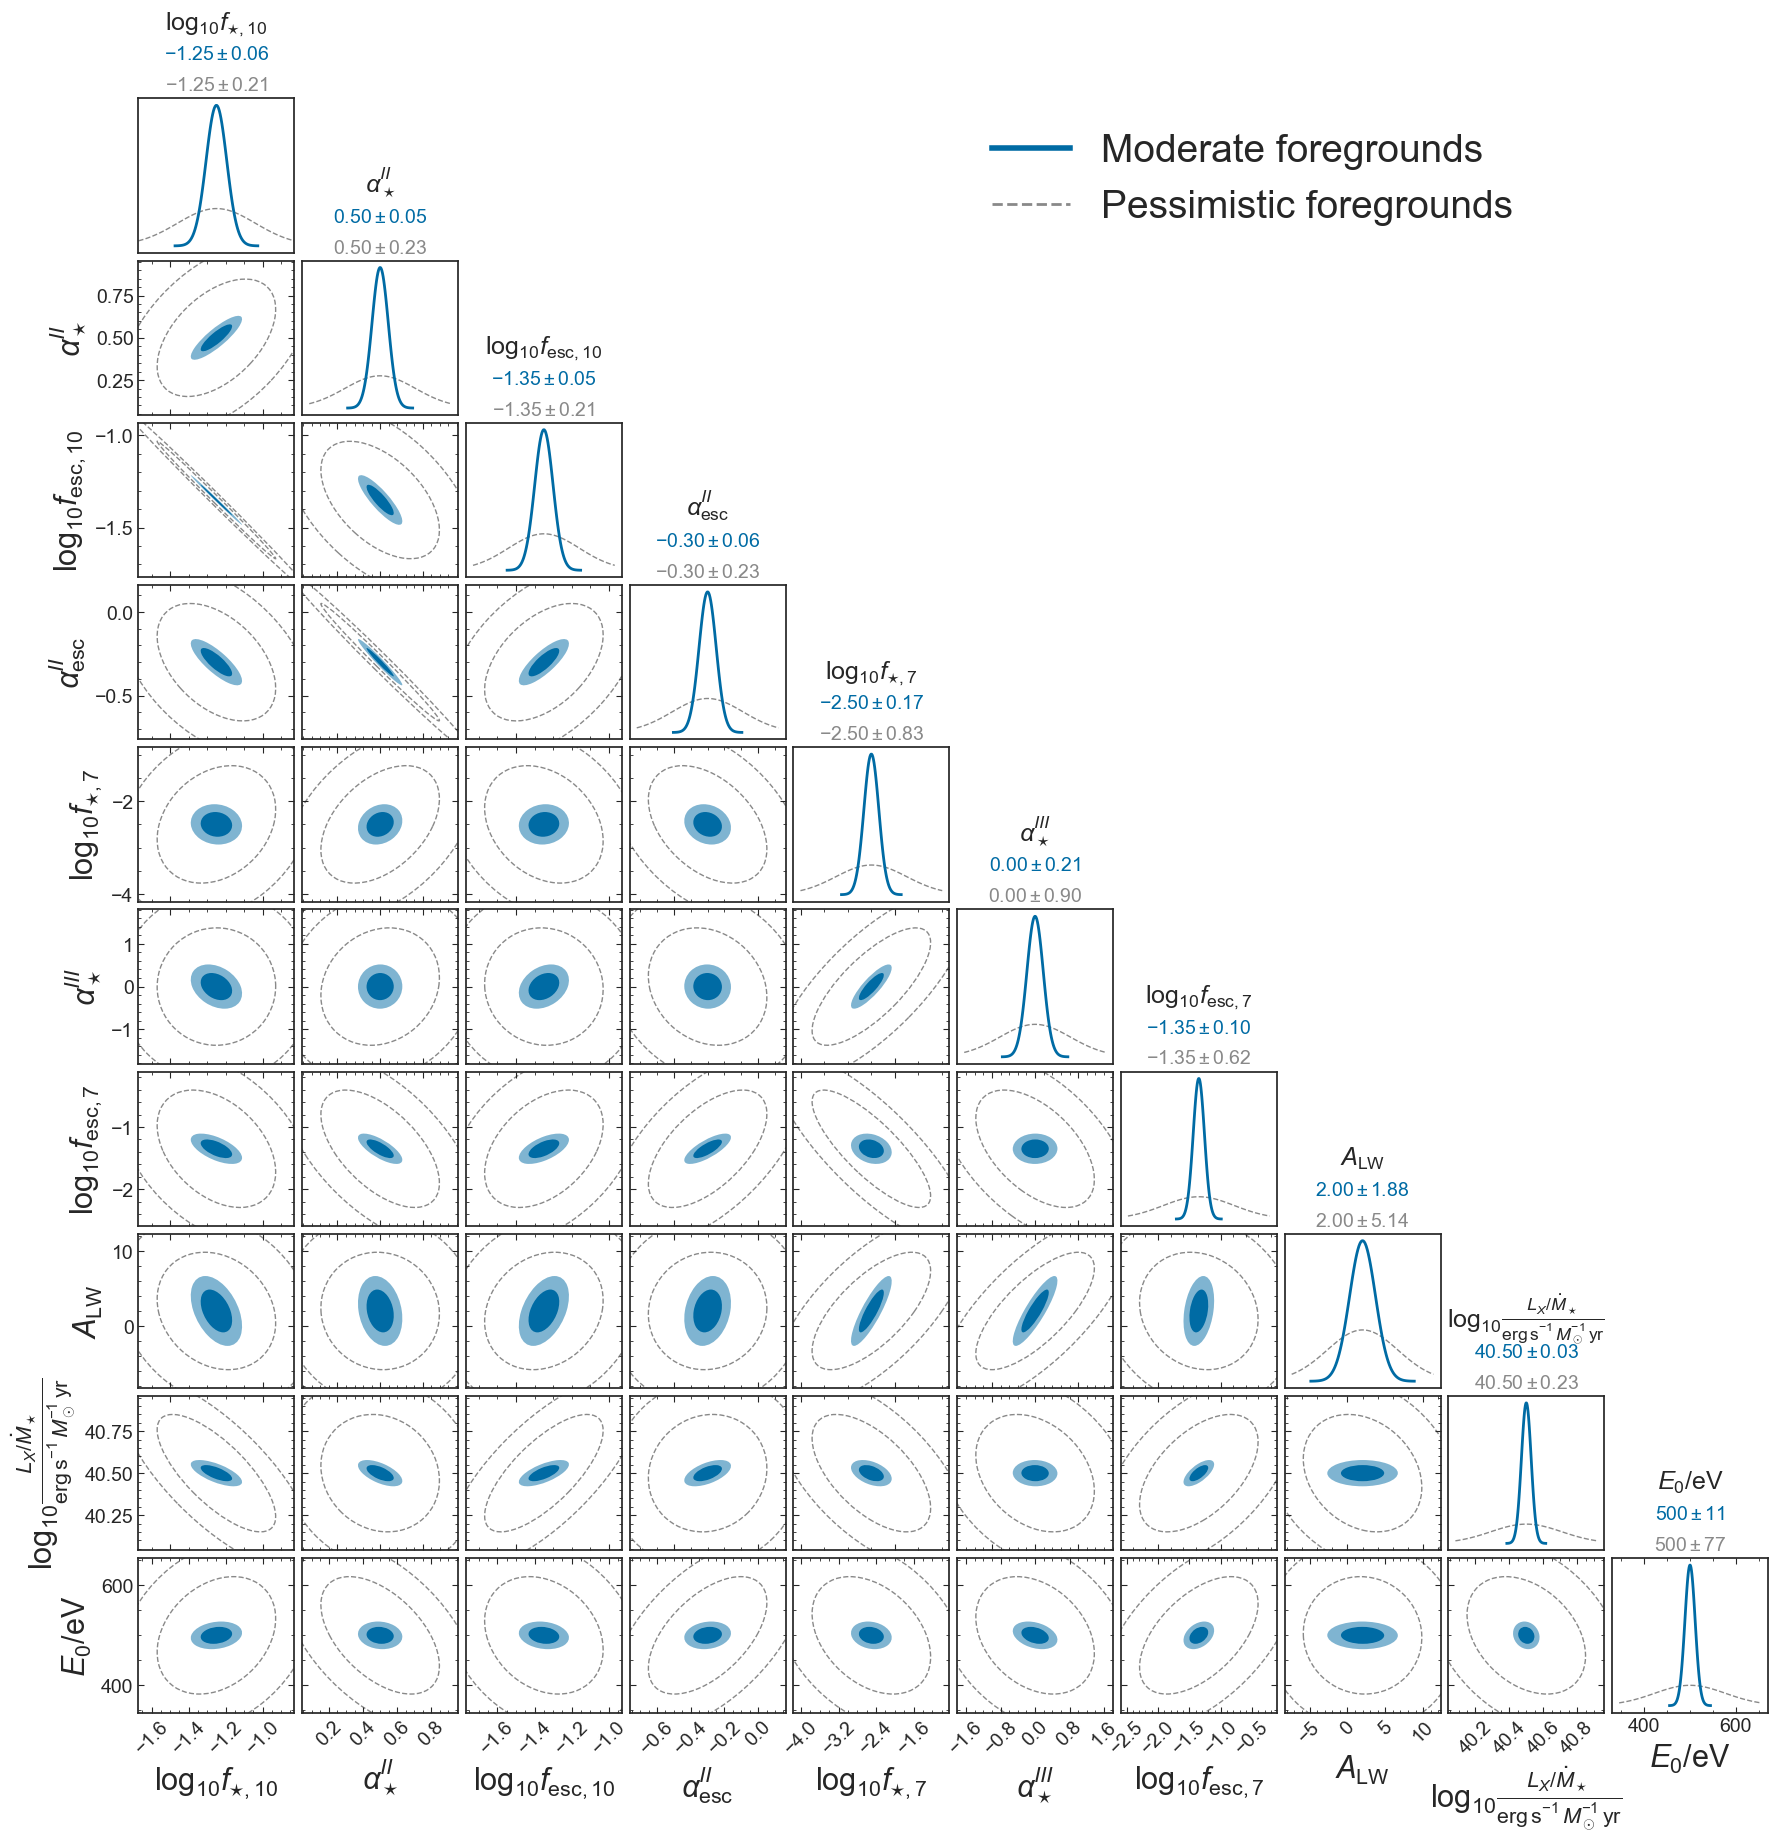

In [16]:
fig, ax = plt.subplots(len(fid_params), len(fid_params), figsize=(18,18))
cols = [col_pess, col_mod]

for i, cov in enumerate([Finv_PS_pess, Finv_PS]):

    col = cols[i]    
    if i == 0:
        # Pessimistic
        resize_lims=True
        plot_rescale=2
        ellipse_color='None'
        ellipse_kwargs=[{'edgecolor':col,'lw':1,'ls':'dashed'},
                      {'edgecolor':col,'lw':1,'ls':'dashed','alpha':1}]
        plot1D_kwargs={'c':col, 'lw':1, 'ls':'dashed'}
    else:
        # Moderate
        ls='solid'
        resize_lims=False
        plot_rescale=4
        ellipse_color=col
        ellipse_kwargs=[{},{'alpha':0.5}]
        plot1D_kwargs={'c':col, 'lw':2}
        
    p21fish.plot_triangle(params=astro_params_vary_EoS, 
                          fiducial=fid_params,
                          labels=fid_labels,
                          cov=cov,
                          ellipse_color=ellipse_color,
                          ellipse_kwargs=ellipse_kwargs,
                          plot1D_kwargs=plot1D_kwargs,
                          resize_lims=resize_lims,
                          plot_rescale=plot_rescale,
                          title_fontsize=14,
                          xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ax=ax, fig=fig);

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels,
               med=fid_params, sigma=np.sqrt(cov.diagonal()),
               title_fontsize=18, title_pad=50,
               vspace=i/5, color=col)

no_prior = mlines.Line2D([], [], color=col_pess, lw=2, ls='dashed', label='Pessimistic foregrounds')
w_prior  = mlines.Line2D([], [], color=col_mod, lw=4, label=r'Moderate foregrounds')

ax[0,5].legend(handles=[w_prior, no_prior], loc='upper left', fontsize=28)

plt.savefig(figs_dir+'corner_EoS_mini_fisher_pessimistic.png', bbox_inches='tight')

## Comparison of forecasts

### S/N

218.50718001785071 285.78849803538145


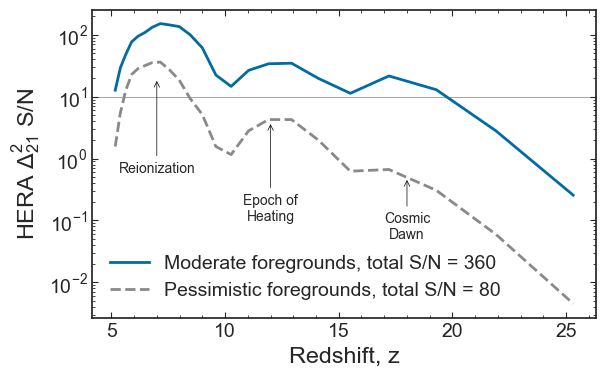

In [17]:
param_test = params_EoS['ALPHA_ESC']
param_test_pess = params_EoS_pess['ALPHA_ESC']

SNR = np.zeros((len(param_test.PS_z_HERA),2))
for i in range(len(param_test.PS_z_HERA)):
    PS = param_test.PS['CDM']['ALPHA_ESC=-0.3'][i]['delta']
    k  = param_test.PS['CDM']['ALPHA_ESC=-0.3'][i]['k'][~np.isnan(PS)]
    PS = PS[~np.isnan(PS)]
    
    # Get rid of nans and interp PS on HERA grid
    PS_interp = np.interp(param_test.PS_err[i]['k']*0.7, 
                           k, PS)
    
    # Use HERA errors
    PS_err = np.array([param_test.PS_err[i]['err_mod'],
                        param_test_pess.PS_err[i]['err_mod']])
    
    SNR[i] = np.sqrt(np.sum((PS_interp/PS_err)**2., axis=1))

SNR_EoR = np.sqrt(np.sum(SNR[:,0][param_test.PS_z_HERA<7.]**2.)) # ~300
SNR_CD  = np.sqrt(np.sum(SNR[:,0][param_test.PS_z_HERA>=7.]**2.)) # ~300

print(SNR_EoR, SNR_CD)
    
plt.figure(figsize=(6.5,4))
labels = ['Moderate','Pessimistic']
cols = [col_mod, col_pess]
lss  = ['solid', 'dashed']
for i, s in enumerate(SNR.T):
    SNR_total = np.sqrt(np.sum(s**2.)) # ~300
    plt.plot(param_test.PS_z_HERA, s, c=cols[i], ls=lss[i], label=f'{labels[i]} foregrounds, total S/N = {SNR_total:.0f}')
plt.xlabel('Redshift, z')
plt.ylabel('HERA $\Delta_{21}^2$ S/N')

plt.annotate("Reionization", xy=(7, 20),  xycoords='data',
            xytext=(7, 0.6), ha='center', fontsize=10,
            arrowprops=dict(arrowstyle="->", lw=0.5))

plt.annotate("Epoch of\nHeating", xy=(12, 4),  xycoords='data',
            xytext=(12, 0.1), ha='center', fontsize=10,
            arrowprops=dict(arrowstyle="->", lw=0.5))

plt.annotate("Cosmic\nDawn", xy=(18, 0.5),  xycoords='data',
            xytext=(18, 0.05), ha='center', fontsize=10,
            arrowprops=dict(arrowstyle="->", lw=0.5))

plt.axhline(10., lw=0.5, ls='solid', c='0.5', zorder=0)
plt.legend()


plt.yscale('log')
plt.savefig(figs_dir+'SNR_EoS.pdf', bbox_inches='tight')

### Errors for each parameter

ALPHA_STAR is at index=1


/var/folders/sy/j00h6jjd19z46r9qd031n3080000gn/T/ipykernel_46372/693560164.py:22: RuntimeWarning: divide by zero encountered in true_divide
  frac_err = np.abs(err/mean)
/var/folders/sy/j00h6jjd19z46r9qd031n3080000gn/T/ipykernel_46372/693560164.py:22: RuntimeWarning: divide by zero encountered in true_divide
  frac_err = np.abs(err/mean)
/var/folders/sy/j00h6jjd19z46r9qd031n3080000gn/T/ipykernel_46372/693560164.py:22: RuntimeWarning: divide by zero encountered in true_divide
  frac_err = np.abs(err/mean)
/var/folders/sy/j00h6jjd19z46r9qd031n3080000gn/T/ipykernel_46372/693560164.py:22: RuntimeWarning: divide by zero encountered in true_divide
  frac_err = np.abs(err/mean)
/var/folders/sy/j00h6jjd19z46r9qd031n3080000gn/T/ipykernel_46372/693560164.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(fid_labels, rotation = 90, ha="center")


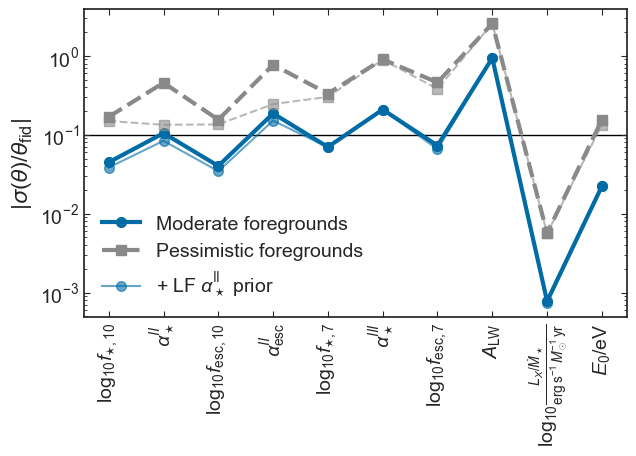

In [18]:
cols    = [col_mod, col_pess, col_mod, col_pess]
lss     = ['solid', 'dashed','solid', 'dashed']
lws     = [3,3,1.5,1.5]
markers = ['o','s','o','s']
labels  = ['Moderate foregrounds','Pessimistic foregrounds',r'+ LF $\alpha_\star^\mathrm{II}$ prior','']#r'with LF $\alpha_\star^\mathrm{II}$ prior']
alphas  = [1,1,0.6,0.6]

# Add alpha star II prior
sigma_alpha_star_II = 0.07
idx_alpha_star = list(params_EoS).index("ALPHA_STAR")
print(f'ALPHA_STAR is at index={idx_alpha_star}')
Fij_matrix_PS_alpha_star_prior_pess = Fij_matrix_PS_pess.copy()
Fij_matrix_PS_alpha_star_prior_pess[idx_alpha_star,idx_alpha_star] += 1/sigma_alpha_star_II**2.
Finv_alpha_star_prior_pess = np.linalg.inv(Fij_matrix_PS_alpha_star_prior_pess)

# Fractional error
plt.figure(figsize=(7,4))
for cc, cov in enumerate([Finv_PS, Finv_PS_pess, Finv_alpha_star_prior, Finv_alpha_star_prior_pess]):
    mean = fid_params
    err  = np.sqrt(np.diag(cov))
    
    frac_err = np.abs(err/mean)
    frac_err[np.isinf(frac_err)] = err[np.isinf(frac_err)]#/0.01
    
    plt.semilogy(fid_labels, frac_err, c=cols[cc], marker=markers[cc], 
                 lw=lws[cc], ls=lss[cc], label=labels[cc], ms=7, alpha=alphas[cc])

# plt.ylim(0.,2.)
plt.axhline(0.1, lw=1, c='k', zorder=0)
plt.legend()
plt.gca().set_xticklabels(fid_labels, rotation = 90, ha="center")
plt.minorticks_on()
plt.gca().tick_params(axis='x', which='minor', bottom=False, top=False)
plt.ylabel('Fractional error')
plt.ylabel(r'$|\sigma(\theta)/\theta_\mathrm{fid}|$')

plt.savefig(figs_dir+'fraction_error_EoS.pdf', bbox_inches='tight')

## Parameter uncertainty as a function of z

How does noise on each parameter change as a function of z?

In [20]:
# Rolling loop through HERA z_bins
z_bins = params_EoS['ALPHA_STAR'].PS_z_HERA
bin_i = 2

z_err = np.zeros((len(z_bins)-bin_i,len(params_EoS)))
for zz in range(len(z_bins)):
    if zz < len(z_bins) - bin_i:
        Fij_matrix_PS_z, Finv_PS_z = p21fish.make_fisher_matrix(params_EoS, 
                                                         fisher_params=astro_params_vary_EoS, 
                                                         hpeak=0.0, obs='PS',
                                                         k_min=0.1, k_max=1, 
                                                         z_min=z_bins[zz], z_max=z_bins[zz+bin_i], 
                                                         sigma_mod_frac=0.2,
                                                         add_sigma_poisson=True)

        z_err[zz] = np.sqrt(np.diag(Finv_PS_z))
    try:
        print(z_err[zz])
    except:
        print(f'could not do for z_min={z_bins[zz]}')

PS shape: (3, 24)
[1.73627339e-01 3.21997284e-01 1.64274933e-01 3.54371796e-01
 6.43228227e-01 2.18440916e+00 9.14333462e-01 5.47960990e+00
 3.31960353e+00 1.41965402e+03]
PS shape: (3, 24)
[5.69850700e-01 4.33426673e-01 5.74504689e-01 4.71365660e-01
 9.38422255e-01 2.81596463e+00 1.19019524e+00 5.66340515e+00
 3.30127823e+00 1.41117918e+03]
PS shape: (3, 24)
[9.57823876e-01 6.25345235e-01 9.83876034e-01 6.19645407e-01
 2.09700055e+00 3.04682008e+00 2.35507809e+00 9.08661934e+00
 4.95058623e+00 2.28170497e+03]
PS shape: (3, 24)
[1.29039754e+00 1.11743289e+00 1.28640278e+00 1.09660340e+00
 2.43973823e+00 3.56788641e+00 2.20000473e+00 1.01747053e+01
 5.53384048e+00 3.14006363e+03]
PS shape: (3, 24)
[1.42347618e+00 1.02975807e+00 1.42237059e+00 1.00031553e+00
 2.35255424e+00 3.45803485e+00 2.42988755e+00 1.01283615e+01
 3.89155274e+00 2.44288794e+03]
PS shape: (3, 24)
[2.00898199e+00 1.03708211e+00 2.05638690e+00 1.00663800e+00
 2.80485967e+00 3.93572488e+00 2.85483480e+00 1.14190180e+01


/var/folders/sy/j00h6jjd19z46r9qd031n3080000gn/T/ipykernel_46372/1430737097.py:30: RuntimeWarning: divide by zero encountered in true_divide
  frac_err = z_err[:,pp]/fid_params[pp]


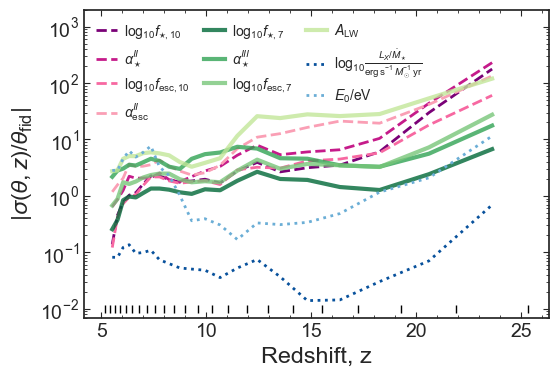

In [22]:
from palettable.colorbrewer.sequential import Blues_5, YlGn_5, RdPu_6

z_plot = (z_bins[bin_i:]+z_bins[bin_i-1:-1])/2

fig1, ax1 = plt.subplots(1,1, figsize=(6,4))

sum_err = np.zeros(len(astro_params_vary_EoS))
for pp,p in enumerate(astro_params_vary_EoS):
    if pp < 4:
        # popII
        ls = 'dashed'
        lw = 2
        colors = RdPu_6.hex_colors[::-1]
        i = pp
        alpha=1
    elif 3 < pp <= 7:
        ls = 'solid'
        lw = 3
        colors = YlGn_5.hex_colors[::-1]
        alpha=0.8
        i = pp-4
    else:
        ls = 'dotted'
        lw = 2
        colors = Blues_5.hex_colors[::-1]
        i = (pp-8)*2
        alpha=1
    
#     print(p, pp, i)
    frac_err = z_err[:,pp]/fid_params[pp]
    frac_err[np.isinf(frac_err)] = z_err[:,pp][np.isinf(frac_err)]
    
    sum_err[pp] = np.sqrt(np.mean(np.abs(frac_err)**2.))
#     print(p, sum_err[pp])
 
    ax1.semilogy(z_plot, np.abs(frac_err), label=fid_labels[pp], 
                 c=colors[i], ls=ls, lw=lw, alpha=alpha)

ax1.legend(ncol=3, fontsize=10, handlelength=1.5, handletextpad=0.5, columnspacing=1., loc='upper left')

ax1.set_xlabel('Redshift, z')
ax1.set_ylabel('$\sigma$')
ax1.set_ylabel(r'$|\sigma(\theta, z)/\theta_\mathrm{fid}|$')
    

plt.plot(z_bins, [0.01]*len(z_bins), '|', color='k')

plt.ylim(7e-3, 2e3)
plt.savefig(figs_dir+'fraction_error_EoS_z.pdf', bbox_inches='tight')

# Comparison to Park+19

Compare Fisher matrix with [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) fiducial to their MCMC (21cm power spectrum only)

In [24]:
output_dir_Park19 = data_dir+'Park19/'
PS_err_dir_Park19 = noise_dir+'21cmSense_noise_Park19/'
        
astro_params_vary_Park19, astro_params_fid_Park19 = p21fish.get_params_fid(
                                                    config_file=p21fish.base_path+'21cmFAST_config_files/Park19.config')

# Reorder to match Park+19
astro_params_vary_Park19 = ['F_STAR10', 'ALPHA_STAR',
                             'F_ESC10', 'ALPHA_ESC', 
                             'M_TURN', 't_STAR', 
                             'L_X', 'NU_X_THRESH']

In [25]:
# Load parameters
params_Park19 = {}
for param in astro_params_vary_Park19:
        
    params_Park19[param] = p21fish.Parameter(param=param, 
                                             output_dir=output_dir_Park19,
                                             HII_DIM=128, BOX_LEN=250,
                                             min_redshift=5.9,
                                             PS_err_dir=PS_err_dir_Park19,
                                             clobber=False, Park19='real',
                                             vb=False, new=False)

########### fisher set up for F_STAR10
    Loading global signal and power spectra from saved files
    Fiducial: F_STAR10=-1.3
########### fisher set up for ALPHA_STAR
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_STAR=0.5
########### fisher set up for F_ESC10
    Loading global signal and power spectra from saved files
    Fiducial: F_ESC10=-1.0
########### fisher set up for ALPHA_ESC
    Loading global signal and power spectra from saved files
    Fiducial: ALPHA_ESC=-0.5
########### fisher set up for M_TURN
    Loading global signal and power spectra from saved files
    Fiducial: M_TURN=8.7
########### fisher set up for t_STAR
    Loading global signal and power spectra from saved files
    Fiducial: t_STAR=0.5
########### fisher set up for L_X
    Loading global signal and power spectra from saved files
    Fiducial: L_X=40.5
########### fisher set up for NU_X_THRESH
    Loading global signal and power spectra from saved files
    Fiducial: NU_X

## Make Fisher matrix

In [26]:
Fij_matrix_PS_Park19, Finv_PS_Park19 = p21fish.make_fisher_matrix(params_Park19, 
                                                                fisher_params=astro_params_vary_Park19, 
                                                                hpeak=0.0, obs='PS',
                                                                k_min=0.1, k_max=1, 
                                                                z_min=5.7, z_max=30., 
                                                                sigma_mod_frac=0.2,
                                                                cosmo_key='CDM',
                                                                add_sigma_poisson=True) 

fid_params_Park19 = np.array([astro_params_fid_Park19[param] for param in params_Park19])
fid_labels_Park19 = np.array([p21fish.astro_params_labels[param] for param in params_Park19])

PS shape: (12, 23)


## Load Park19 chains and compare

Load their 21cm-only chains and compare the contours

['F_STAR10' 'ALPHA_STAR' 'F_ESC10' 'ALPHA_ESC' 'M_TURN' 't_STAR' 'L_X'
 'E0']


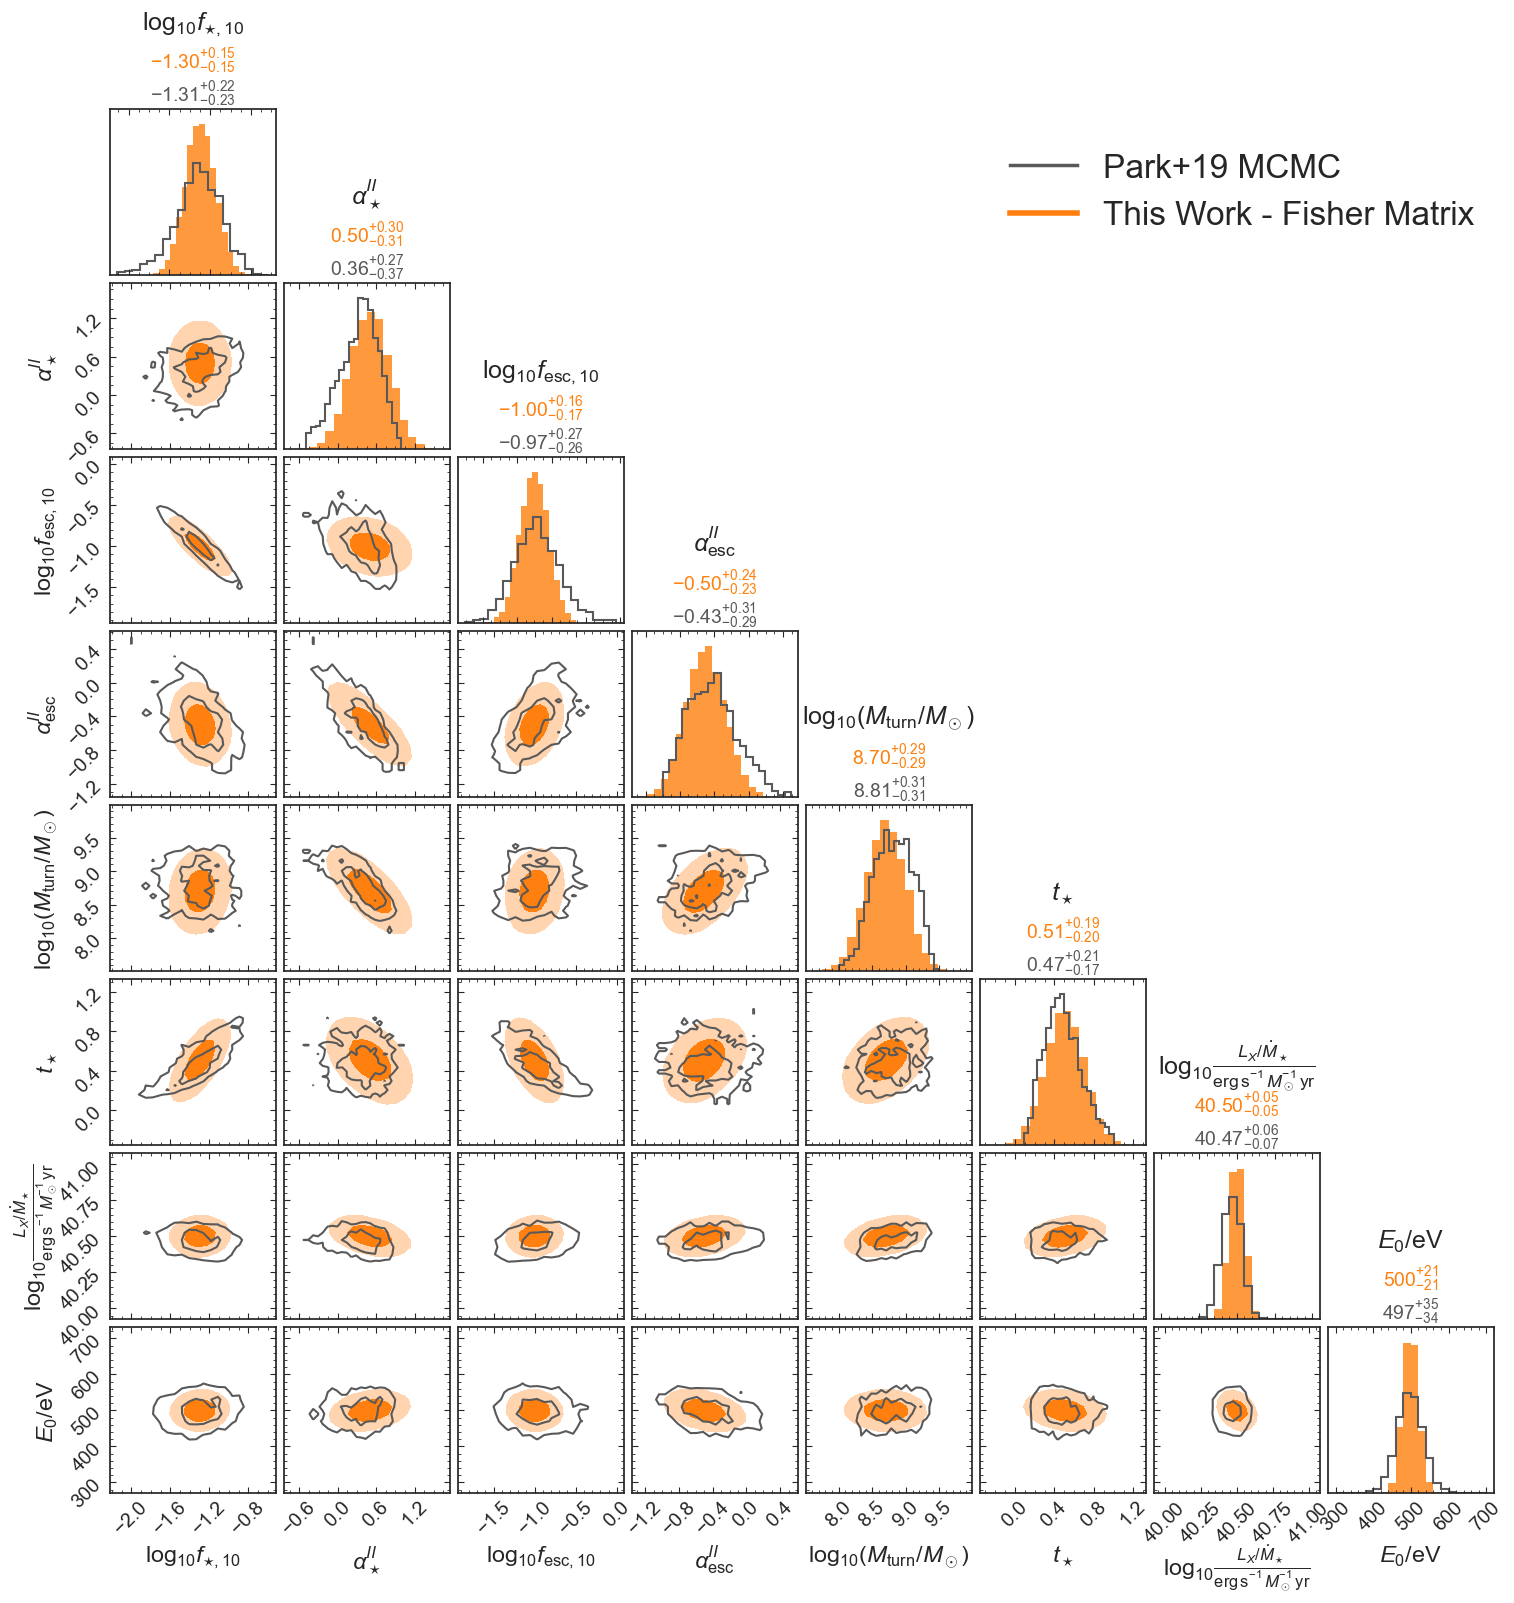

In [28]:
Park19_chains = np.load(f'{data_dir}Park19/Park19_chains.npz')
print(Park19_chains['params'])

# Make posteriors from the covariance matrix
mean = fid_params_Park19.copy()
cov  = Finv_PS_Park19.copy()
fisher_chain = np.random.multivariate_normal(mean, cov, size=10000)

# Corner plot
fig = plt.figure(figsize=(15,15))

colors = [col_mcmc,col_P19]
lws = [1.5,3]

# Plot 2 sigma confidence interval (https://corner.readthedocs.io/en/latest/pages/sigmas.html)
levels = 1.0 - np.exp(-0.5 * np.array([1,2,]) ** 2)
    
for cc, chain in enumerate([Park19_chains['chains'],fisher_chain]):

    if cc == 0:
        # MCMC
        ls='solid'
        lw=lws[cc]
        hist_kwargs = {'lw':lw,'ls':ls,'density':True}
        color=colors[cc]
        smooth=None
        fill_contours    = False
        no_fill_contours = True
        contour_kwargs = {'linewidths':lw,'linestyles':ls}
        contourf_kwargs={}
        zorder=10
    else:
        # fisher
        ls='solid'
        lw=lws[cc]
        hist_kwargs = {'lw':lw,'density':True,'histtype':'stepfilled', 'alpha':0.8}
        fill_contours=True
        no_fill_contours=False
        color=colors[cc]
        smooth=1
        contour_kwargs = {'linewidths':0.}
        contourf_kwargs = {}
        zorder=0

    corner.corner(chain, fig=fig,              
                labels=fid_labels_Park19,
                smooth=smooth,
                color=color, use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                no_fill_contours=no_fill_contours, fill_contours=fill_contours,
                hist_kwargs=hist_kwargs,
                contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,
                levels=levels,
                range=[1,1,1,1,1,1,(40.,41.),(300,700)], # throws out a couple of outlier points in the chains [better for Lx]
                show_titles=True,
                zorder=zorder
                );

    # Format the quantile display
    ax = np.reshape(fig.axes, (chain.shape[1],chain.shape[1]))

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels_Park19,
                   chain=chain, 
                   med=None, sigma=None,
                   title_fontsize=18, title_pad=58,
                   vspace=cc/5,
                   color=color
                   )

lab_P19 = mlines.Line2D([], [], color=col_mcmc, ls='solid', lw=lws[0]+1, label='Park+19 MCMC')
lab_TW  = mlines.Line2D([], [], color=col_P19, lw=lws[1]+1, label=r'This Work - Fisher Matrix')

fig.get_axes()[5].legend(handles=[lab_P19, lab_TW], loc='center left', fontsize=24)

plt.savefig(figs_dir+'corner_Park19_fisher_compare_2sigma.png', bbox_inches='tight')

# Adding a new parameter

If you want to add your own new parameter, you should:

1. Create lightcones varying that parameter.
    1. Create a config file for the parameters you want to change (take one of the examples in `../21cmFAST_config_files/` and replace the `astro_params_vary` list with your list of new parameters.
    2. Note that the fiducial parameter value for your new parameter will be the 21cmFAST default unless the fiducial value is specified in the config file. If you want a non-default fiducial parameter value you will need to create a new set of lightcones with your parameter's fiducial included in `astro_params`.
    3. Create the lightcones using `scripts/make_lightcones_for_fisher.py`
2. Load your new parameter by adding it to the dictionary [as above](#EOS21)

See more details on running `scripts/make_lightcones_for_fisher.py` in the [docs](https://21cmfish.readthedocs.io/en/latest/usage.html) 